# ENSE 471 - Winter 2018 - Assignment 1
## Adam Tilson


## FFMPEG Frontend - Phase 2
### To be completed once you have finished Lab 2

### Changelog:
The assignment may undergo revision. This section will track changes.

    V1.0 - Initial assignment posted.
    V1.1 - Changes added for greater compatibility with text parsing in different operating systems
    V1.2 - Changes in V1.1 made more explicit

### Objective: Provide additional usability improvements to the FFMPEG FrontEnd

Now that you have successfully implemented a frontend for FFMPEG, you are likely aware that there are some serious usability limitations with the interface as created.  Before going any further, take a moment to think of any usability bugs that you have found, and using the Heuristic Evaluation with Nielsens Usability Heurstics, enter them in the table in the cell below.


|severity|heuristic|description|
|---|---|-----|
|2|Visibility of System Status|Encoding the video freezes the whole program and does not indicate progress|
|2|Recognition vs Recall|Program requires you to know/memorize the path of the file|
|3|Error Prevention|Trying to encode a video with an invalid file will error and crash the program|
|1|Help and Documentation|There is no way for a user to know what 'Low' 'Medium' and 'High' encodings are|
|2|Error Prevention|Leaving the output file blank will error the program|
|3|User Control and Freedom|Cannot cancel the encoding process if running on a potato and accidentally selected 'High'|
|3|Visibility of System Status|User has no idea that the program is meant to convert a video unless told in person|
|2|Error Prevention|No indication or check on specific input file types|
|2|Recognize, Diagnose, and recover from errors|Output files could be of any file format|
|1|Consistency and Standards|Kivy dropdowns are not very obvious that they are dropdowns|

We will now begin remedying some of these usability errors. In particular we will:
- Add a file selection dialoge
- Add additional codecs and parameters to be selected
- Automatically generate appropriate output file names
- Add a proper preview function that allows the user to preview their encoding before committing
- (Optionally) Add a progress bar so that the user may see the progress of their encoding
- Modify the interface to allow these additional options to be selected.



# Interface Goal:

The goal for the interface is shown below:

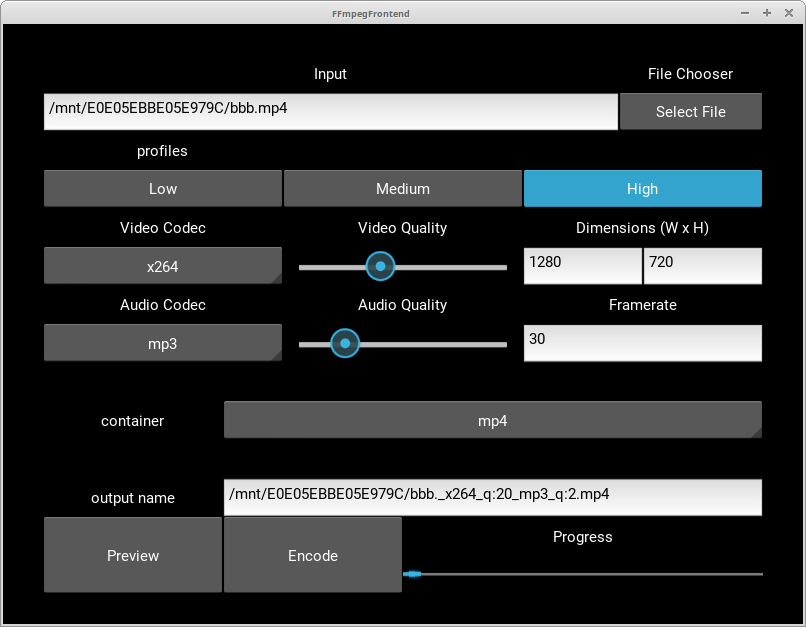

To fully understand the interface, a brief video was recorded which walks through the interface, and may viewed below:

In [1]:
# run me!
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/NbwhZzPofx8" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>')

As before, we will explore some of the requisite understandings and implement some of the vital functionaility ahead of time, so that it can then be integrated independantly into the interface.

## Part 1: Using the File Selection Dialogue 

Kivy provides a method for selecting files automatically. The following code block demonstrates this process, and is derived from the example shown here:

https://kivy.org/docs/api-kivy.uix.filechooser.html

In particular, what is happening in this code is:
- Two custom widgets are created, Loader and LoadDialog
- The Loader Widget is created when the App is built
- When we load button, we create a pop-up window which has the file selector widget.
- We can use this to select the file.
- The filename is inserted into the appropriate filebox.
    
You may switch the file selector style from the FileChooserListView to the FileChooserIconView by modifying the correct line in the LoadDialog section of the dotKV string. 
    
Using this code, you can add functionality to your form.

In [2]:
dotKV = '''\
<Loader>:
    BoxLayout:
        orientation: 'vertical'
        BoxLayout:
            Button:
                text: 'Select File'
                on_release: root.show_load()
        BoxLayout:
            TextInput:
                id: text_input
                text: ''

<LoadDialog>:
    BoxLayout:
        size: root.size
        pos: root.pos
        orientation: "vertical"
        FileChooserListView:
            id: filechooser
        BoxLayout:
            size_hint_y: None
            height: 30
            Button:
                text: "Cancel"
                on_release: root.cancel()

            Button:
                text: "Select Video"
                on_release: root.load(filechooser.path, filechooser.selection)
'''

from kivy.lang import Builder
Builder.load_string(dotKV)

from kivy.config import Config
Config.set('graphics', 'fullscreen', '0')

from kivy.app import App
from kivy.uix.floatlayout import FloatLayout
from kivy.properties import ObjectProperty
from kivy.uix.popup import Popup

import os

class LoadDialog(FloatLayout):
    load = ObjectProperty(None)
    cancel = ObjectProperty(None)


class Loader(FloatLayout):
    def dismiss_popup(self):
        self._popup.dismiss()

    def show_load(self):
        content = LoadDialog(load=self.load, cancel=self.dismiss_popup)
        self._popup = Popup(title="Load file", content=content, size_hint=(0.9, 0.9))
        self._popup.open()

    def load(self, path, filename):
        self.ids.text_input.text = os.path.join(path, filename[0])
        self.dismiss_popup()

class EditorApp(App):
    def build(self):
        return Loader()

if __name__ == '__main__':
    EditorApp().run()

[INFO   ] [Logger      ] Record log in C:\Users\Quinn\.kivy\logs\kivy_18-02-02_7.txt
[INFO   ] [Kivy        ] v1.10.0
[INFO   ] [Python      ] v3.6.3 |Anaconda, Inc.| (default, Oct 15 2017, 03:27:45) [MSC v.1900 64 bit (AMD64)]
[INFO   ] [Factory     ] 194 symbols loaded
[INFO   ] [Image       ] Providers: img_tex, img_dds, img_sdl2, img_pil, img_gif (img_ffpyplayer ignored)
[INFO   ] [Text        ] Provider: sdl2
[INFO   ] [OSC         ] using <thread> for socket
[INFO   ] [Window      ] Provider: sdl2
[INFO   ] [GL          ] Using the "OpenGL" graphics system
[INFO   ] [GL          ] GLEW initialization succeeded
[INFO   ] [GL          ] Backend used <glew>
[INFO   ] [GL          ] OpenGL version <b'4.6.0 NVIDIA 388.13'>
[INFO   ] [GL          ] OpenGL vendor <b'NVIDIA Corporation'>
[INFO   ] [GL          ] OpenGL renderer <b'GeForce GTX 1060 3GB/PCIe/SSE2'>
[INFO   ] [GL          ] OpenGL parsed version: 4, 6
[INFO   ] [GL          ] Shading version <b'4.60 NVIDIA'>
[INFO   ] [GL  

### Requirements for your assignment:

For your assignment you should create the File Chooser button with the text "Select File". When the user clicks on this button the file selection dialogue should appear. You can then select a video, and the file name should appear in the input file textbox. This functionality will apply to the following portion of the interface:

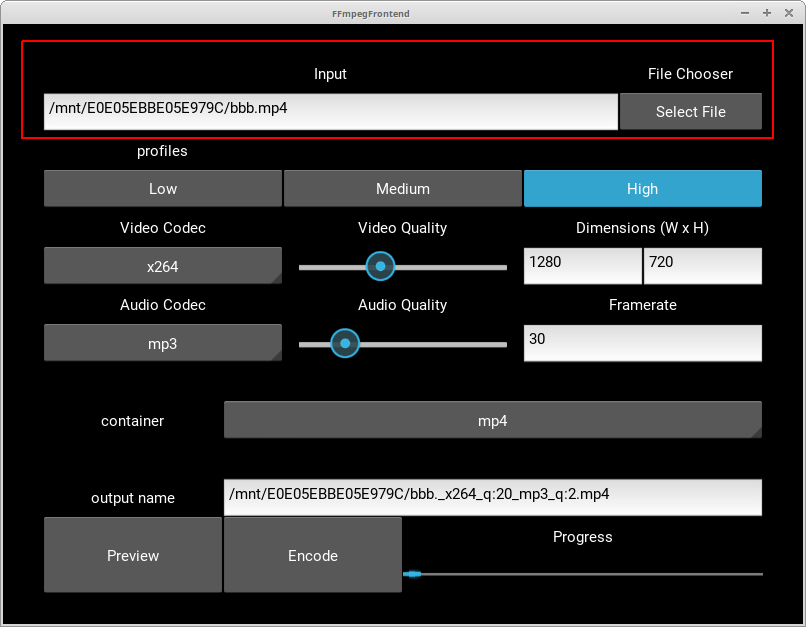

## Part 2: Understanding Video File Formats and Containers

A video file stored on a computer is comprised of a container, and one or more streams. Streams typically include a video stream, one or more audio streams, and may include one or more subtitle streams. Each of these streams is compressed using a different algorithm which is best suited to compressing that type of data, that is, reducing the file size at a cost of reducing the quality by potentially introducing some visually or audibly recognizable distortions, known as artifacts. The container format holds the streams together and synchronizes them following some standard.

To allow greater functionality of our application, we will allow the user to select between different containers, different video compression encoders, and different audio compression encoders.

A "codec" is an encoder / decoder application which can convert a stream into the desired format. It should be noted that the encoder and the format are different things: the lame encoder creates mp3 files.

Some codecs may not be included in all FFMPEG builds, depending on the arguments used. In particular, libfdk_aac is likely missing from most builds of FFMPEG as it is non GPL.

A brief discription of available codecs is shown below:

With most codecs, lower q values are typically lower compression rates. Exceptions to this is are libfdk_aac and libvorbis.

audio codecs

|format name | encoder name | ffmpeg_name | notes | quality flag | quality values | highest | default value |
|-|-|-|-|
|mp3 | lame | libmp3lame | common compressed audio encoder | -q:a | 0 - 9 | 0 | 5 | 
|ogg vorbis | vorbis | libvorbis | a free, open source alternative to mp3 | -q:a | 0 - 10 | 10 | 5 |
|flac| flac | flac | a lossless audio codec (best quality, biggest file size)| -q:a | 0 - 12 | 0 | 5 |

video codecs

|format name | encoder name | ffmpeg_name | notes | quality flag | quality values | highest | default value |
|-|-|-|-|
|h263 | xvid | libxvid | old, somewhat outdated video format | -q:v | 1 - 31 | 1 | 20 |
|h264 | x264 | libx264 | common video format with good compression and quality | -q:v |  0 - 51 | 0 | 20 | 
|h265| x265 | libx265 | better compression and quality, but requires a longer encoding time | -q:v | 0 - 51 | 0 | 20 |

There are two types of containers which are typically used, Matroska which is open source, and MP4 which is proprietary. Typically one chooses the appropriate container based on the target device which needs to read the file. 

*Note: Some audio and video objects may not be compatible with some containers. More information can be found here: 
https://en.wikipedia.org/wiki/Comparison_of_video_container_formats* You do not need to enforce these compatibility requirements for this assignment.

### Drill Down Interface Requirements:

In this portion of the Assignment you will add a drill down aspect to your interface. You will add code to the following portion of the interface:

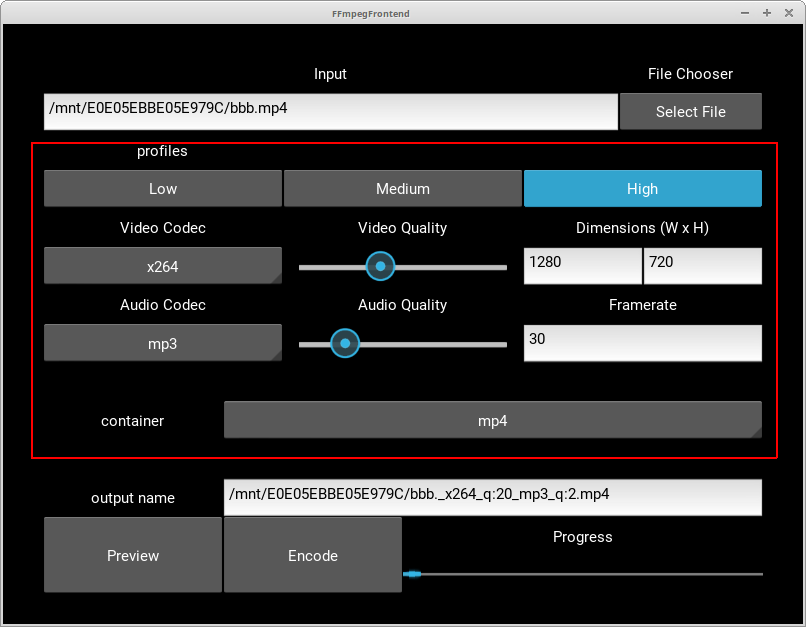

In this portion of the interface, the user will have the ability to press one of the three profile Toggle buttons. These will select one of the three profiles defined earlier, and set the required drop downs and sliders. The user may then optionally further drill down the implentation of the interface using the spinners, sliders and textboxes as follows:

Video Codec:
    Select between x264, x265 and xvid
 
Audio Codec:
    Select between mp3, vorbis and flac
    
Video Quality: Set the video Q value for the codec, as per table above. You will need to find some way to map your slider value, eg. (0..100) to your codec range of expected values, eg. (1-31), perhaps through a linear transformation.

Audio Quality: Set the audio Q value for the codec, as per table above. You will need to do the same process as with the Video Quality.

Width: Set the width. This should ideally be an integer power of 2, or at the very least divisible by 2, but we do not need to sanatize our inputs.

Height: Set the height. The same constrains apply as to width.

Framerate: Set the framerate of the output video. 

Depending on how the user sets these values, you will need to generate an FFMPEG command line to handle this input, which should be triggered by the "Encode" button.

## Part 3: Automatic Filename Output Generation

In this portion of the workbook we will cause our interface to automatically generate an output filename based on the selected settings. 

### Automatic File Name Requirements:

The program should automatically generate a filename based on the input filename, and the settings of the audio and video encoders in the following format:

```
<original filename>_<video codec>_q-v_<video q value>_<audio codec>_q-a_<audio q value>.<container extension>

eg. bbb.mp4 

becomes:

bbb_x264_q-v_20_mp3_q-a_5.mkv
```

Use the following video encoder names: x264, x265, xvid

Use the following audio encoder names: mp3, vorbis, flac

Appropriate container extensions are: mp4, mkv (matroska)

Some hints:
you can strip the extension of a filename using the string slice operator, eg. filename[:-4], this strips the rightmost four characters from the string.

The Output File generation should occur when any of the profile or drill down options are changed. You will need to find the appropriate on_event for your function. Some examples may be: on_text, on_value 

Once you have the filename generated, store it in the Output file box shown below:

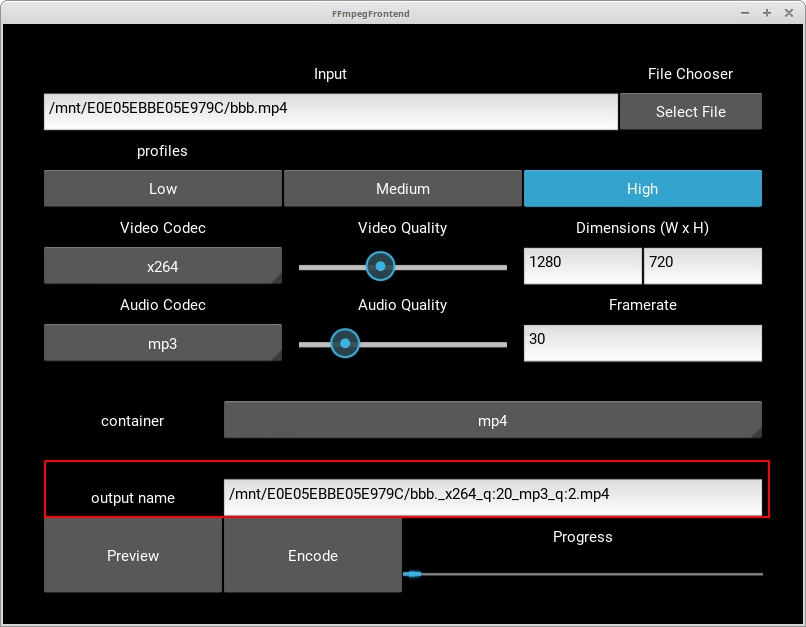

## Part 4: Preview function

In this portion of the workbook we will give functionality to the following portion of the interface:

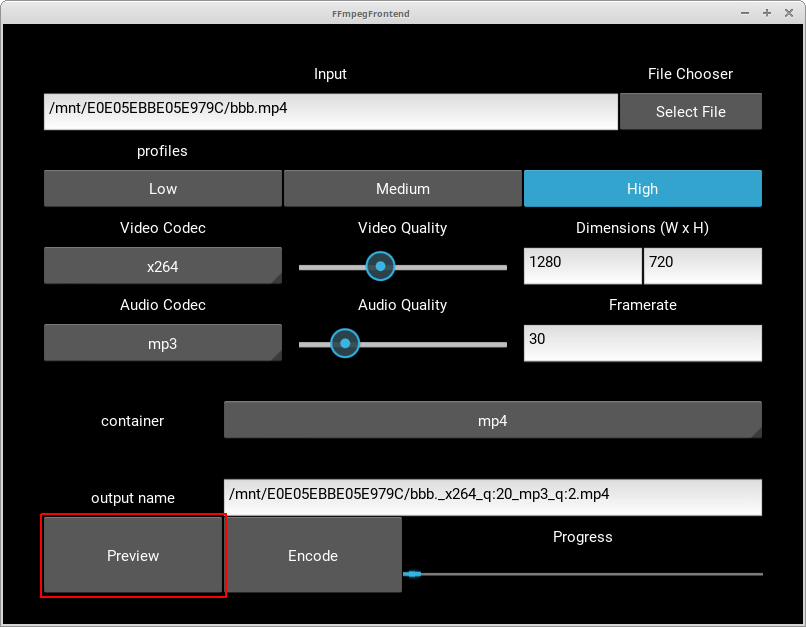

In the lab phase, we had the preview function just play the input video using FFPLAY. While useful for checking to see if we selected the correct video, it would be more useful to actually see the encoding process before we dispatch the job to the CPU. To do this, we need to start the encoding process, but rather than saving this output to a file, we need to stream it FFPLAY. The command for streaming a video from ffmpeg to ffplay is as follows:
```
ffmpeg -i input.avi <options> -f matroska - | ffplay -
```
If you have never seen a piping operation before, the way that this operation works is, the operation on the left of the pipe ("|") occurs first, and the output is sent to the command on the right as in the input. By convention, when using piping operations we use the dash argument "-" to mean read from stdin or write to stdout.

The only unexpected portion of this command is that, in ffmpeg, we need to state the format of the output container, since it can't be inferred from the output file's extension, since we are not writing to a file and are instead writing to stdout. We state the format of our output container using the "-f" argument.

In python this process is a bit more complicated. We need to create our two processes, saving references to them as variables, and feed the stdout of the first into the second. 

```
from subprocess import Popen, PIPE

p1 = Popen(<first command as a list of strings>, stdout=PIPE)
p2 = Popen(<second command as a list of strings>, stdin=p1.stdout)
```

If we set our first command as our encode command, and our second to our ffplay command, we should expect it to work. Try this in the following cell. Remember to encode your commands as lists of strings, with one string for each argument.:

In [3]:
from subprocess import Popen, PIPE

def pipe (firstCommand, secondCommand):
    pass # your code here.

## Part 5: Encoding the File

To actually encode the file, we need to simply generate the encoding command and open an FFMPEG instance. This can be done in much the same way as in the lab, the big difference being that we need to adjust more parameters.

### Requirements for Encoding Files

The encoding command must adjust based on the users selection to all of the drill down options, including:
- input file name
- video codec
- video quality
- audio codec
- audio quality
- output dimensions
- framerate
- container
- output file name

Creating this command is also required to achieve the preview button functionality.

Once you have the encoding string set, invoke the FFMPEG command line and wait for the encoding to finish. 

## Part 6: (Optional) Updating the Progress Bar during an encode

The purpose of this portion of the assignment is to allow the user to see the progress of the updating process by updating the progress bar.

Optional: This section is optional, but implementing it will help you better understand python and kivy, and would be a significant first step if you choose to expand on the FFMPEG Frontend as the term project. 

In this section of the assignment we will update this portion of the interface:

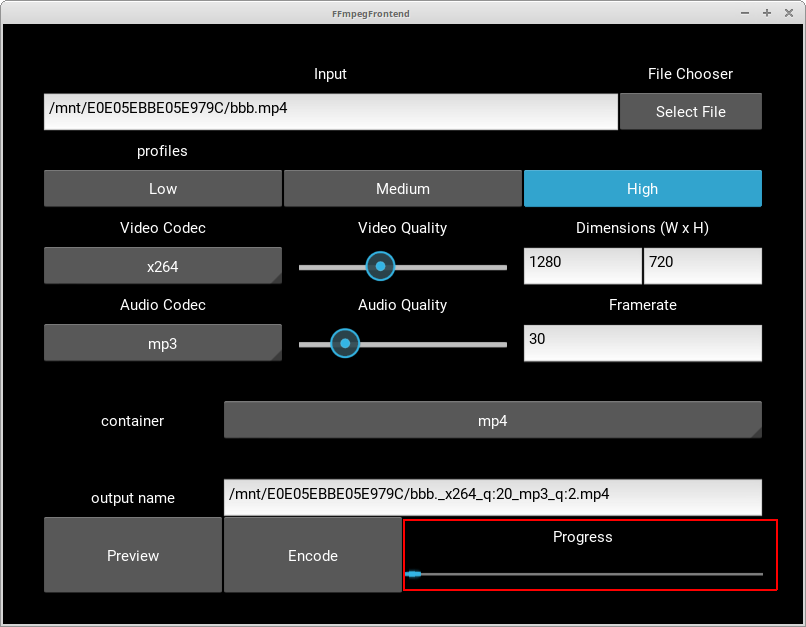

Making the progress bar work properly is a significant undertaking. There are two primary challenges to be completed:

1. We must grab the output of the FFMPEG command line application, and process it. This information is provided as stderr information on the console. We must use string parsing methods to find what we want from this data. In particular we must find:
        i. The duration of the video file
        ii. The current point in the file
        iii. The ratio of the current point to the duration.
    This involves reading information from the command line, and processing every line in the output in a loop.
    
    Some code to help you get started in this process is included below:

* V1.2 NOTE: This code has been updated to work with more operating systems.

```
p = Popen(encodeCmd, stdout=PIPE, stderr=STDOUT, bufsize=1, universal_newlines=True)
    with p.stdout:
        tmp = ""
        delims = {"\n", "\r"}
        for ch in iter(lambda: p.stdout.read(1), ""):
            if ch in delims:
                line = tmp
                tmp = ""
                if "Duration:" in line: # returns the line with the duration
                    print (line)               
                if "time=" in line: # returns any line which contains the word time
                    print (line)
            else:
                tmp += ch
        
    p.wait()
```

This code will invoke the encodeCmd, and capture the output. It will print the line which includes the word "Duration" and any line which includes "time". The line which include Duration includes the total length of the video. Any lines which include time show the current progress of the video. If you divide the time value by the duration value, you will get the total progress through the video.

Unfortunately, this is in a line which contains other, unneeded information, and is also in an unintuitive format. You will need to extract the time stamp of the "Duration" and "time" first (hint: use the split operation and the list access [] commands). You will also need to convert the time to integers for the division to occur properly. The timestamp format which ffmpeg uses is given as follows:
    
    hh:mm:ss:nn 
    
    where 
    hh = number of hours
    mm = number of minutes
    ss = number of seconds
    nn = hundreths of a second

It may be a good idea to parse this string, convert it to an integer (total number of hundreths), and divide to get the current progress as a percentage. This value can then be used to update the progress bar.
    
2. Updating the progress bar

    An unfortunate side effect of waiting on FFMPEG and reading the output in a loop is that we will monopolize the python thread. Because of this, control will never be returned to Kivy to update the GUI until the operation is complete, so we will not actually be able to see the progress bar. The only way to circumvent this is to run the encode function in a separate thread, and update the Kivy Gui at regular intervals in the main thread. Some code to get you started in this is as follows:  

```
from kivy.clock import Clock, mainthread


# we will use this function as a callback to update the progressbar GUI
@mainthread     # this function always runs in the main thread
def updateProgressBar (self, *args):
    pass # add your code in this function to update the progress bar

# we will use this function in a second thread to encode the video
def encodeThread (self, encodeCmd, UpdatePBScheduler):
    # do all of your Popen encoding stuff here 
    
    # once your encoding finishes, you can cancel the update event
    UpdatePBScheduler.cancel() 


# call this function when you want to encode the video
def encode (self):
    #get your encode command here
    encodeCmd = ...
    
    # schedule your main thread to call the updateProgressBar every 1 second.
    UpdatePBScheduler = Clock.schedule_interval(self.updateProgressBar, 1)
    
    # create a new thread and dispatch the FFMPEG encode thread here
    threading.Thread(target=self.encodeThread, args=(encodeCmd, UpdatePBScheduler,)).start()
```        

This should be enough code to get the progress bar working with a little effort.

## Part 7: Putting it all together 

It's time to build the interface. You may use the code in the following cell as a backbone, or start from the completion of Lab 1. Good luck!

In [1]:
dotKV = '''\

# Write your dotKV file in here. Be sure to use proper formatting.
<FfmpegFrontendWidget>:
    orientation: "vertical"
    padding: "20px"
    BoxLayout:
        orientation: "horizontal"
        Label:
            text: "Input File"
            size_hint_x: 0.8
        Label:
            text: "File Chooser"
            size_hint_x: 0.2
    BoxLayout:
        orientation: "horizontal"
        TextInput:
            id: txtInputFile
            text: "Input File Name"
            size_hint_x: 0.8
        Button:
            text: "Select Input File"
            size_hint_x: 0.2
            on_release: root.showFiles()
    BoxLayout:
        orientation: "horizontal"
        Label:
            text: "Profiles"
    BoxLayout:
        orientation: "horizontal"
        ToggleButton:
            group: "profile"
            text: "Low"
            on_release: root.clickProfile("Low")
        ToggleButton:
            group: "profile"
            text: "Medium"
            on_release: root.clickProfile("Medium")
        ToggleButton:
            group: "profile"
            text: "High"
            on_release: root.clickProfile("High")
    BoxLayout:
        orientation: "horizontal"
        Label:
            text: "Video Codec"
        Label:
            text: "Video Quality"
        Label:
            text: "Dimenstions (W x H)"
    BoxLayout:
        orientation: "horizontal"
        Spinner:
            values: ('x264', 'x265', 'xvid')
            text: 'x264'
            id: videoCodec
            on_text: root.updateSliderRange()
        Slider:
            range: (0, 51)
            value: 20
            id: videoQuality
            on_touch_up: root.updateOutputFileName()
        BoxLayout:
            orientation: "horizontal"
            TextInput:
                text: "1280"
                id: videoWidth
            TextInput:
                text: "720"
                id: videoHeight
    BoxLayout:
        Label:
            text: "Audio Codec"
        Label:
            text: "Audio Quality"
        Label:
            text: "Framerate (fps)"
    BoxLayout:
        orientation: "horizontal"
        Spinner:
            values: ('mp3', 'vorbis', 'flac')
            text: 'mp3'
            id: audioCodec
            on_text: root.updateSliderRange()
        Slider:
            range: (0, 12)
            value: 5
            id: audioQuality
            on_touch_up: root.updateOutputFileName()
        BoxLayout:
            orientation: "horizontal"
            TextInput:
                text: "60"
                id: framerate
    BoxLayout:
        padding: [0, 10, 0, 0]
        orientation: "horizontal"
        Label:
            text: "Video Format"
            size_hint_x: 0.2
        Spinner:
            values: ('mp4', 'mkv')
            text: 'mp4'
            id: videoFormat
            on_text: root.updateOutputFileName()
    BoxLayout:
        padding: [0, 10, 0, 0]
        orientation: "horizontal"
        Label:
            text: "Output File Name"
            halign: 'left'
            size_hint_x: 0.2
        TextInput:
            id: txtOutputFile
            text: "Output File Name"
    BoxLayout:
        padding: [0, 10, 0, 0]
        orientation: "horizontal"
        Button:
            text: 'Preview'
            on_press: root.preview()
        Button:
            text: 'Encode'
            on_press: root.encode()
    BoxLayout:
        padding: [0, 10, 0, 0]
        orientation: "horizontal"
        ProgressBar:
            id: progressBar
            
<Loader>:
    BoxLayout:
        orientation: 'vertical'
        BoxLayout:
            Button:
                text: 'Select File'
                on_release: root.show_load()
        BoxLayout:
            TextInput:
                id: text_input
                text: ''

<LoadDialog>:
    BoxLayout:
        size: root.size
        pos: root.pos
        orientation: "vertical"
        FileChooserListView:
            id: filechooser
        BoxLayout:
            size_hint_y: None
            height: 30
            Button:
                text: "Cancel"
                on_release: root.cancel()

            Button:
                text: "Select Video"
                on_release: root.load(filechooser.path, filechooser.selection)
\
'''

# build the .kv file from the string
from kivy.lang import Builder
Builder.load_string(dotKV)

# keep the application from going fullscreen
from kivy.config import Config
Config.set('graphics', 'fullscreen', '0')

# the kivy base class import
from kivy.app import App
from kivy.uix.boxlayout import BoxLayout
from kivy.uix.floatlayout import FloatLayout
from kivy.uix.label import Label
from kivy.uix.button import Button
from kivy.uix.textinput import TextInput
from kivy.uix.spinner import Spinner
from kivy.uix.slider import Slider
from kivy.uix.popup import Popup
from kivy.properties import ObjectProperty
from kivy.uix.progressbar import ProgressBar

from kivy.clock import Clock, mainthread

import threading
import os

ffmpegPath = "C:\\Users\\Quinn\\Desktop\\ffmpeg-3.4.1-win64-static\\ffmpeg-3.4.1-win64-static\\bin"
   
class FfmpegFrontendWidget(BoxLayout):
    
    progress = 0
    duration = 0
       
    def updateOutputFileName(self):
        #<original filename>_<video codec>_q-v_<video q value>_<audio codec>_q-a_<audio q value>.<container extension>
        audioQuality = str(round(self.ids.audioQuality.value)) if (self.ids.audioCodec.text == "vorbis") else str(round(self.ids.audioQuality.max - self.ids.audioQuality.value))
        fileOptions = [self.ids.txtInputFile.text[:-4],
                          self.ids.videoCodec.text,
                           "q-v",
                          str(round(self.ids.videoQuality.value)),
                          self.ids.audioCodec.text,
                           "q-a",
                          audioQuality]
        
        self.ids.txtOutputFile.text = ("_".join(fileOptions)) + "." + self.ids.videoFormat.text
        
    def updateSliderRange(self):
        audio = self.ids.audioCodec.text
        video = self.ids.videoCodec.text
        if(audio == "mp3"):
            self.ids.audioQuality.range = (0,9)
        elif(audio == "vorbis"):
            self.ids.audioQuality.range = (0, 10)
        elif(audio == "flac"):
            self.ids.audioQuality.range = (0,12)
            
        if(video == "x264") or (video == "x265"):
            self.ids.videoQuality.range = (0,51)
        elif(video == "xvid"):
            self.ids.videoQuality.range = (1, 31)
            
        self.updateOutputFileName()
            
        
    def clickProfile(self, profileName):
        if(profileName == "Low"):
            self.ids.videoCodec.text = "x264"
            self.ids.videoQuality.value = 51 - 30
            self.ids.audioCodec.text = "mp3"
            self.updateSliderRange()
            self.ids.audioQuality.value = 12 - (5 * (12/9))
            self.ids.videoWidth.text = "640"
            self.ids.videoHeight.text = "360"
            self.ids.framerate.text = "24"
        elif(profileName == "Medium"):
            self.ids.videoCodec.text = "x264"
            self.ids.videoQuality.value = 51 - 24
            self.ids.audioCodec.text = "mp3"
            self.updateSliderRange()
            self.ids.audioQuality.value = 12 - (5 * (12/9))
            self.ids.videoWidth.text = "852"
            self.ids.videoHeight.text = "480"
            self.ids.framerate.text = "24"
        elif(profileName == "High"):
            self.ids.videoCodec.text = "x264"
            self.ids.videoQuality.value = 51 - 20
            self.ids.audioCodec.text = "mp3"
            self.updateSliderRange()
            self.ids.audioQuality.value = 12 - (2 * (12/9))
            self.ids.videoWidth.text = "1280"
            self.ids.videoHeight.text = "720"
            self.ids.framerate.text = "30"
        
        self.ids.videoFormat.text = "mp4"
        self.updateOutputFileName()
    
    def preview(self):
        
        from subprocess import Popen, PIPE
        parameters = self.getEncodeParameters()
        parameters.pop()
        parameters += ["-f", "matroska", "-"]
        
        print(parameters)
        play = [ffmpegPath + "\\ffplay", "-"]
        
        p1 = Popen(parameters, stdout=PIPE)
        p2 = Popen(play, stdin=p1.stdout)
        
    def getEncodeParameters(self):
        baseEncode = "-i filename -r framerate -s widxheight -c:v videocodec -crf videoquality -c:a audiocodec -q:a audioquality outputfile"
        audioQuality = str(round(self.ids.audioQuality.value)) if (self.ids.audioCodec.text == "vorbis") else str(round(self.ids.audioQuality.max - self.ids.audioQuality.value))
        
        if(self.ids.audioCodec.text == "mp3"):
            audioCodec = "libmp3lame"
        elif(self.ids.audioCodec.text == "vorbis"):
            audioCodec = "libvorbis"
        elif(self.ids.audioCodec.text == "flac"):
            audioCodec = "flac"            
        
        baseParams = baseEncode.split(" ")
        baseParams[1] = self.ids.txtInputFile.text
        baseParams[3] = self.ids.framerate.text
        baseParams[5] = self.ids.videoWidth.text + "x" + self.ids.videoHeight.text
        baseParams[7] = "lib" + self.ids.videoCodec.text
        baseParams[9] = str(round(self.ids.videoQuality.value))
        baseParams[11] = audioCodec
        baseParams[13] = audioQuality
        baseParams[14] = self.ids.txtOutputFile.text
        
        #Get the appropriate command based on the selected encoding
        parameters = [ffmpegPath + "\\ffmpeg"]
        parameters += baseParams
        return parameters
        
    def showFiles(self):
        content = LoadDialog(load=self.load, cancel=self.dismiss_popup)
        self._popup = Popup(title="Load file", content=content, size_hint=(0.9, 0.9))
        self._popup.open()
        
    def dismiss_popup(self):
        self._popup.dismiss()

    def load(self, path, filename):
        self.ids.txtInputFile.text = os.path.join(path, filename[0])
        self.dismiss_popup()
        
    # we will use this function as a callback to update the progressbar GUI
    @mainthread     # this function always runs in the main thread
    def updateProgressBar (self, *args):
        self.ids.progressBar.value = round(self.progress / self.duration * 100)

    # we will use this function in a second thread to encode the video
    def encodeThread (self, encodeCmd, UpdatePBScheduler):
        from subprocess import Popen, PIPE, STDOUT
        # do all of your Popen encoding stuff here 
        p = Popen(encodeCmd, stdout=PIPE, stderr=STDOUT, bufsize=1, universal_newlines=True)
        with p.stdout:
            tmp = ""
            delims = {"\n", "\r"}
            for ch in iter(lambda: p.stdout.read(1), ""):
                if ch in delims:
                    line = tmp
                    tmp = ""
                    if "Duration:" in line: # returns the line with the duration
                        text = line[(line.find("Duration:")+10):(line.find("Duration:")+21)]
                        self.duration = (int(text[0])*10+int(text[1]))*100*60*60+(int(text[3])*10+int(text[4]))*100*60+(int(text[6])*1000+int(text[7])*100)+int(text[9])*10+int(text[10])
                    if "time=" in line: # returns any line which contains the word time
                        text = line[(line.find("time=")+5):line.find("time=")+16]
                        self.progress = (int(text[0])*10+int(text[1]))*100*60*60+(int(text[3])*10+int(text[4]))*100*60+(int(text[6])*1000+int(text[7])*100)+int(text[9])*10+int(text[10])
                else:
                    tmp += ch

        p.wait()

        
        # once your encoding finishes, you can cancel the update event
        if(round(self.progress / self.duration * 100) > 99):
            self.ids.progressBar.value = 0
            UpdatePBScheduler.cancel()


    # call this function when you want to encode the video
    def encode (self):
        #get your encode command here
        encodeCmd = self.getEncodeParameters()

        # schedule your main thread to call the updateProgressBar every 1 second.
        UpdatePBScheduler = Clock.schedule_interval(self.updateProgressBar, 1)

        # create a new thread and dispatch the FFMPEG encode thread here
        threading.Thread(target=self.encodeThread, args=(encodeCmd, UpdatePBScheduler,)).start()
        
# this code will build and run your kivy app        
class FFmpegFrontendApp(App):
    def build(self):
        return FfmpegFrontendWidget()
        
class LoadDialog(FloatLayout):
    load = ObjectProperty(None)
    cancel = ObjectProperty(None)

if __name__ == "__main__":
    FFmpegFrontendApp().run()

[INFO   ] [Logger      ] Record log in C:\Users\Quinn\.kivy\logs\kivy_18-02-08_0.txt
[INFO   ] [Kivy        ] v1.10.0
[INFO   ] [Python      ] v3.6.3 |Anaconda, Inc.| (default, Oct 15 2017, 03:27:45) [MSC v.1900 64 bit (AMD64)]
[INFO   ] [Factory     ] 194 symbols loaded
[INFO   ] [Image       ] Providers: img_tex, img_dds, img_sdl2, img_pil, img_gif (img_ffpyplayer ignored)
[INFO   ] [Text        ] Provider: sdl2
[INFO   ] [OSC         ] using <thread> for socket
[INFO   ] [Window      ] Provider: sdl2
[INFO   ] [GL          ] Using the "OpenGL" graphics system
[INFO   ] [GL          ] GLEW initialization succeeded
[INFO   ] [GL          ] Backend used <glew>
[INFO   ] [GL          ] OpenGL version <b'4.6.0 NVIDIA 388.13'>
[INFO   ] [GL          ] OpenGL vendor <b'NVIDIA Corporation'>
[INFO   ] [GL          ] OpenGL renderer <b'GeForce GTX 1060 3GB/PCIe/SSE2'>
[INFO   ] [GL          ] OpenGL parsed version: 4, 6
[INFO   ] [GL          ] Shading version <b'4.60 NVIDIA'>
[INFO   ] [GL  

## Next Steps:

The FFMPEG Frontend Encoder is one of the four potential options to be further developed as your term project. If you choose to expand on this project, some implementation paths you may choose are:

- Interface Redesign
- Implement Batch Processing
- Allow finer tuning of parameters (CBR, VBR, ABR modes)
- Allow different codecs
- Allow profiles for different mobile devices which ensure compatibility